In [1]:
%matplotlib inline
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res
from utils import *

W0725 21:40:07.322513 139701196052288 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0725 21:40:07.592371 139701196052288 deprecation_wrapper.py:119] From /home/yl238/projects/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/ipynb/utils.py:119: The name tf.InteractiveSession is deprecated. Please use tf.compat.v1.InteractiveSession instead.



## Opening the black box of MCMC
The previous two chapters hid the inner-mechanics of TFP, and more generally Markov Chain Monte Carlo (MCMC), from the reader. The reason for including this chapter is three-fold. The first is that any book on Bayesian inference must discuss MCMC. I cannot fight this. Blame the statisticians. Secondly, knowing the process of MCMC gives you insight into whether your algorithm has converged(Converged to what? We will get to that). Thirdly, we'll understand why we are returned thousands of samples from the posterior as a solution, which at first thought can be odd.

## The Bayesian landscape
When we setup a Bayesian inference problem with $N$ unknowns, we are implicitly creating an $N$ dimensional space for the prior distributions to exist in. Associated with the space is an additional dimension, which we can describe as the surface, or curve, that sits on top of the space, that reflects the prior probability of a particular point. The surface on the space is defined by our prior distributions. For example, if we have two unknowns $p_1$ and $p_2$, and priors for both are $\text{Uniform}(0,5)$, the space created is a square of length 5 and the surface is a flat plane that sits on top of the square (representing that every point is equally likely).

In [13]:
x_ = y_ = np.linspace(0., 5., 100., dtype=np.float32)
X_, Y_ = evaluate(tf.meshgrid(x_, y_))

uni_x_ = evaluate(tfd.Uniform(low=0., high=5.0).prob(x_))
m_ = np.median(uni_x_)

uni_y_ = evaluate(tfd.Uniform(low=0., high=5.).prob(y_))
M_ = evaluate(tf.matmul(tf.expand_dims(uni_x_, 1), tf.expand_dims(uni_y_, 0)))

In [6]:
from mpl_toolkits.mplot3d import Axes3D

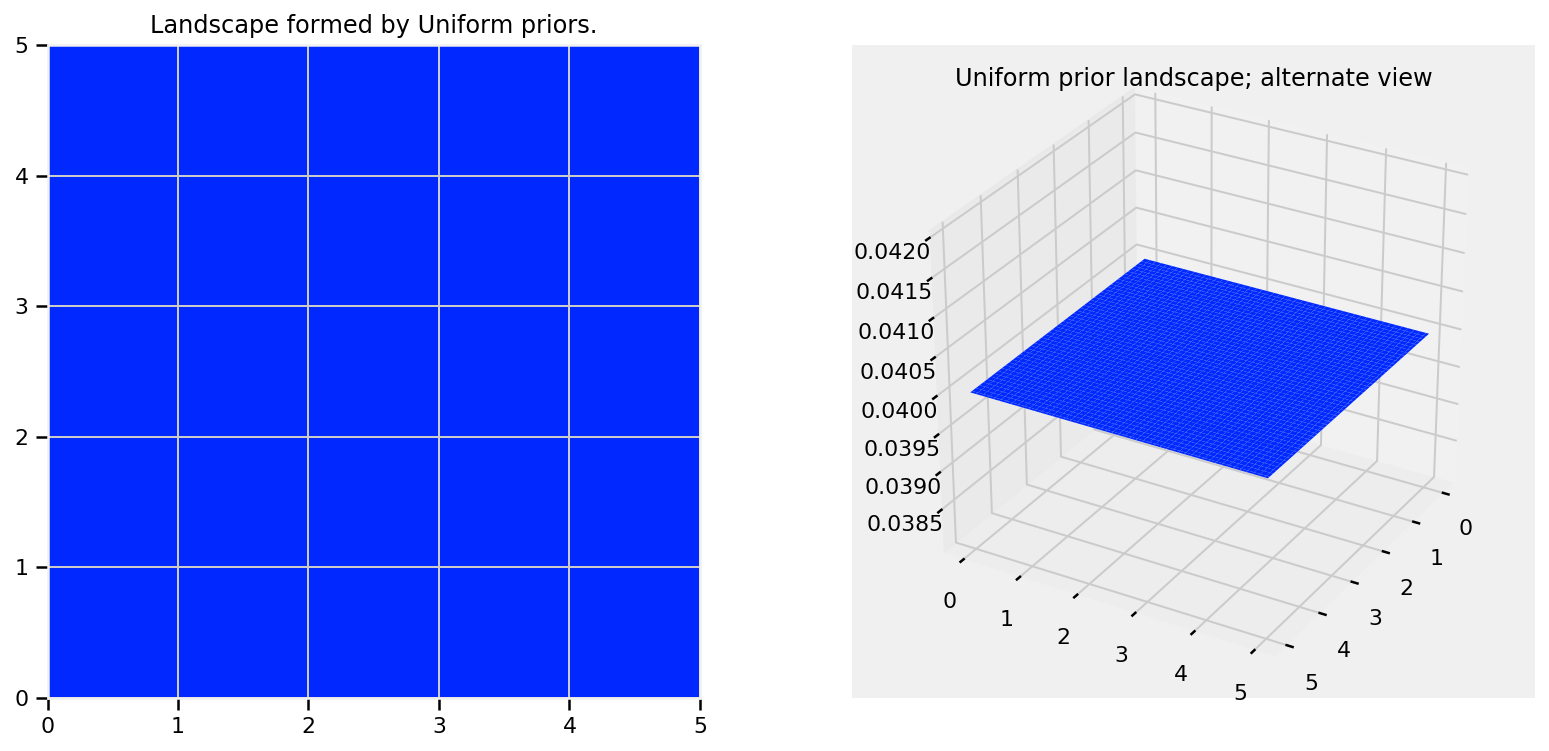

In [8]:
jet = plt.cm.jet
fig = plt.figure(figsize=(12, 6))
plt.subplot(121)
im = plt.imshow(M_, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))

plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Uniform priors.")
 
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X_, Y_, M_, cmap=plt.cm.jet, vmax=1, vmin=-.15)
ax.view_init(azim=390)
plt.title("Uniform prior landscape; alternate view");

Alternatively, if the two priors are $\text{Exp}(3)$ and $\text{Exp}(10)$, then the space is all positive numbers on the 2-D plane, and the surface induced by the priors looks like a water fall that starts at the point (0,0) and flows over the positive numbers.

The plots below visualize this. The more the color, the more prior probability is assigned to that location. Conversely, areas with represent that our priors assign very low probability to that location.

In [14]:
exp_x_ = evaluate(tfd.Exponential(rate=(1./3.)).prob(x_))
exp_y_ = evaluate(tfd.Exponential(rate=(1./10.)).prob(y_))

M_ = evaluate(tf.matmul(tf.expand_dims(exp_x_, 1), tf.expand_dims(exp_y_, 0)))

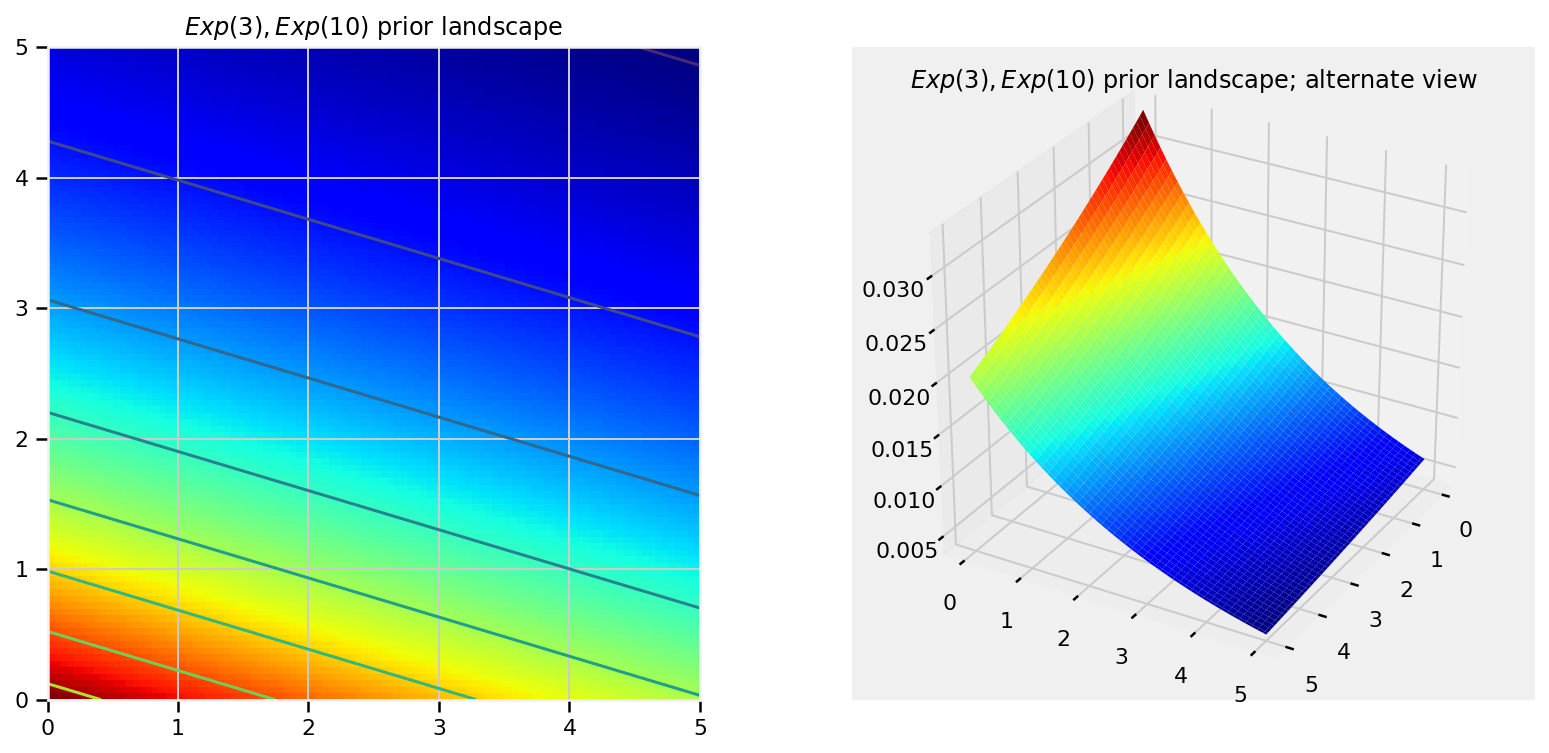

In [15]:
jet = plt.cm.jet
fig = plt.figure(figsize=(12, 6))
plt.subplot(121)
CS = plt.contour(X_, Y_, M_)
im = plt.imshow(M_, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title(r"$Exp(3), Exp(10)$ prior landscape")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X_, Y_, M_, cmap=plt.cm.jet)
ax.view_init(azim=30)
plt.title(r"$Exp(3), Exp(10)$ prior landscape; alternate view");

These are simple examples in 2D space, where our brains can understand surfaces well. In practice, spaces and surfaces generated by our priors can be much higher dimensional.

If these surfaces describe our prior distributions on the unknowns, what happens to our space after we incorporate our observed data  $X$? The data $X$ does not change the space, but it changes the surface of the space by pulling and stretching the fabric of the prior surface to reflect where the true parameters likely live. More data means more pulling and stretching, and our original shape becomes mangled or insignificant compared to the newly formed shape. Less data, and our original shape is more present. Regardless, the resulting surface describes the posterior distribution.

Again I must stress that it is, unfortunately, impossible to visualize this in large dimensions. For two dimensions, the data essentially pushes up the original surface to make tall mountains. The tendency of the observed data to push up the posterior probability in certain areas is checked by the prior probability distribution, so that less prior probability means more resistance. Thus in the double-exponential prior case above, a mountain (or multiple mountains) that might erupt near the (0,0) corner would be much higher than mountains that erupt closer to (5,5), since there is more resistance (low prior probability) near (5,5). The peak reflects the posterior probability of where the true parameters are likely to be found. Importantly, if the prior has assigned a probability of 0, then no posterior probability will be assigned there.

Suppose the priors mentioned above represent different parameters $\lambda$ of two Poisson distributions. We observe a few data points and visualize the new landscape:

In [21]:
# create the observed data
# sample size of data we observe, trying varying this (keep it less than 100 ;)
N = 15 # param {type: 'slider', min:1, max:15, step:1}

# the true parameters, but of course we don't see these values...
lambda_1_true = float(1.)
lambda_2_true = float(3.)

# We see the data generated, dependent on the above two values.
data = tf.concat([
    tfd.Poisson(rate=lambda_1_true).sample(sample_shape=(N, 1), seed=4),
    tfd.Poisson(rate=lambda_2_true).sample(sample_shape=(N, 1), seed=8)
], axis=1)
data_ = evaluate(data)
print('observed (2-dimensional, sample size = %d): \n' % N, data_)

observed (2-dimensional, sample size = 15): 
 [[3. 4.]
 [1. 3.]
 [1. 1.]
 [2. 4.]
 [2. 2.]
 [1. 2.]
 [0. 3.]
 [1. 1.]
 [1. 4.]
 [0. 2.]
 [0. 5.]
 [1. 1.]
 [0. 3.]
 [0. 8.]
 [0. 4.]]


In [22]:
# plotting details.
x_ = y_ = np.linspace(.01, 5, 100)

likelihood_x = tf.math.reduce_prod(tfd.Poisson(rate=x_).prob(data_[:,0][:,tf.newaxis]),axis=0)
likelihood_y = tf.math.reduce_prod(tfd.Poisson(rate=y_).prob(data_[:,1][:,tf.newaxis]),axis=0)

L_ = evaluate(tf.matmul(likelihood_x[:,tf.newaxis],likelihood_y[tf.newaxis,:]))

In [23]:
def plot_contour(M, x, y, lambda_1_true, lambda_2_true, title=None, **kwargs):
    plt.contour(x, y, M)
    im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5), **kwargs)
    plt.title(title)
    plt.scatter(lambda_2_true, lambda_1_true, c='k', s=50, edgecolor='none')
    plt.xlim(0, 5)
    plt.ylim(0, 5)

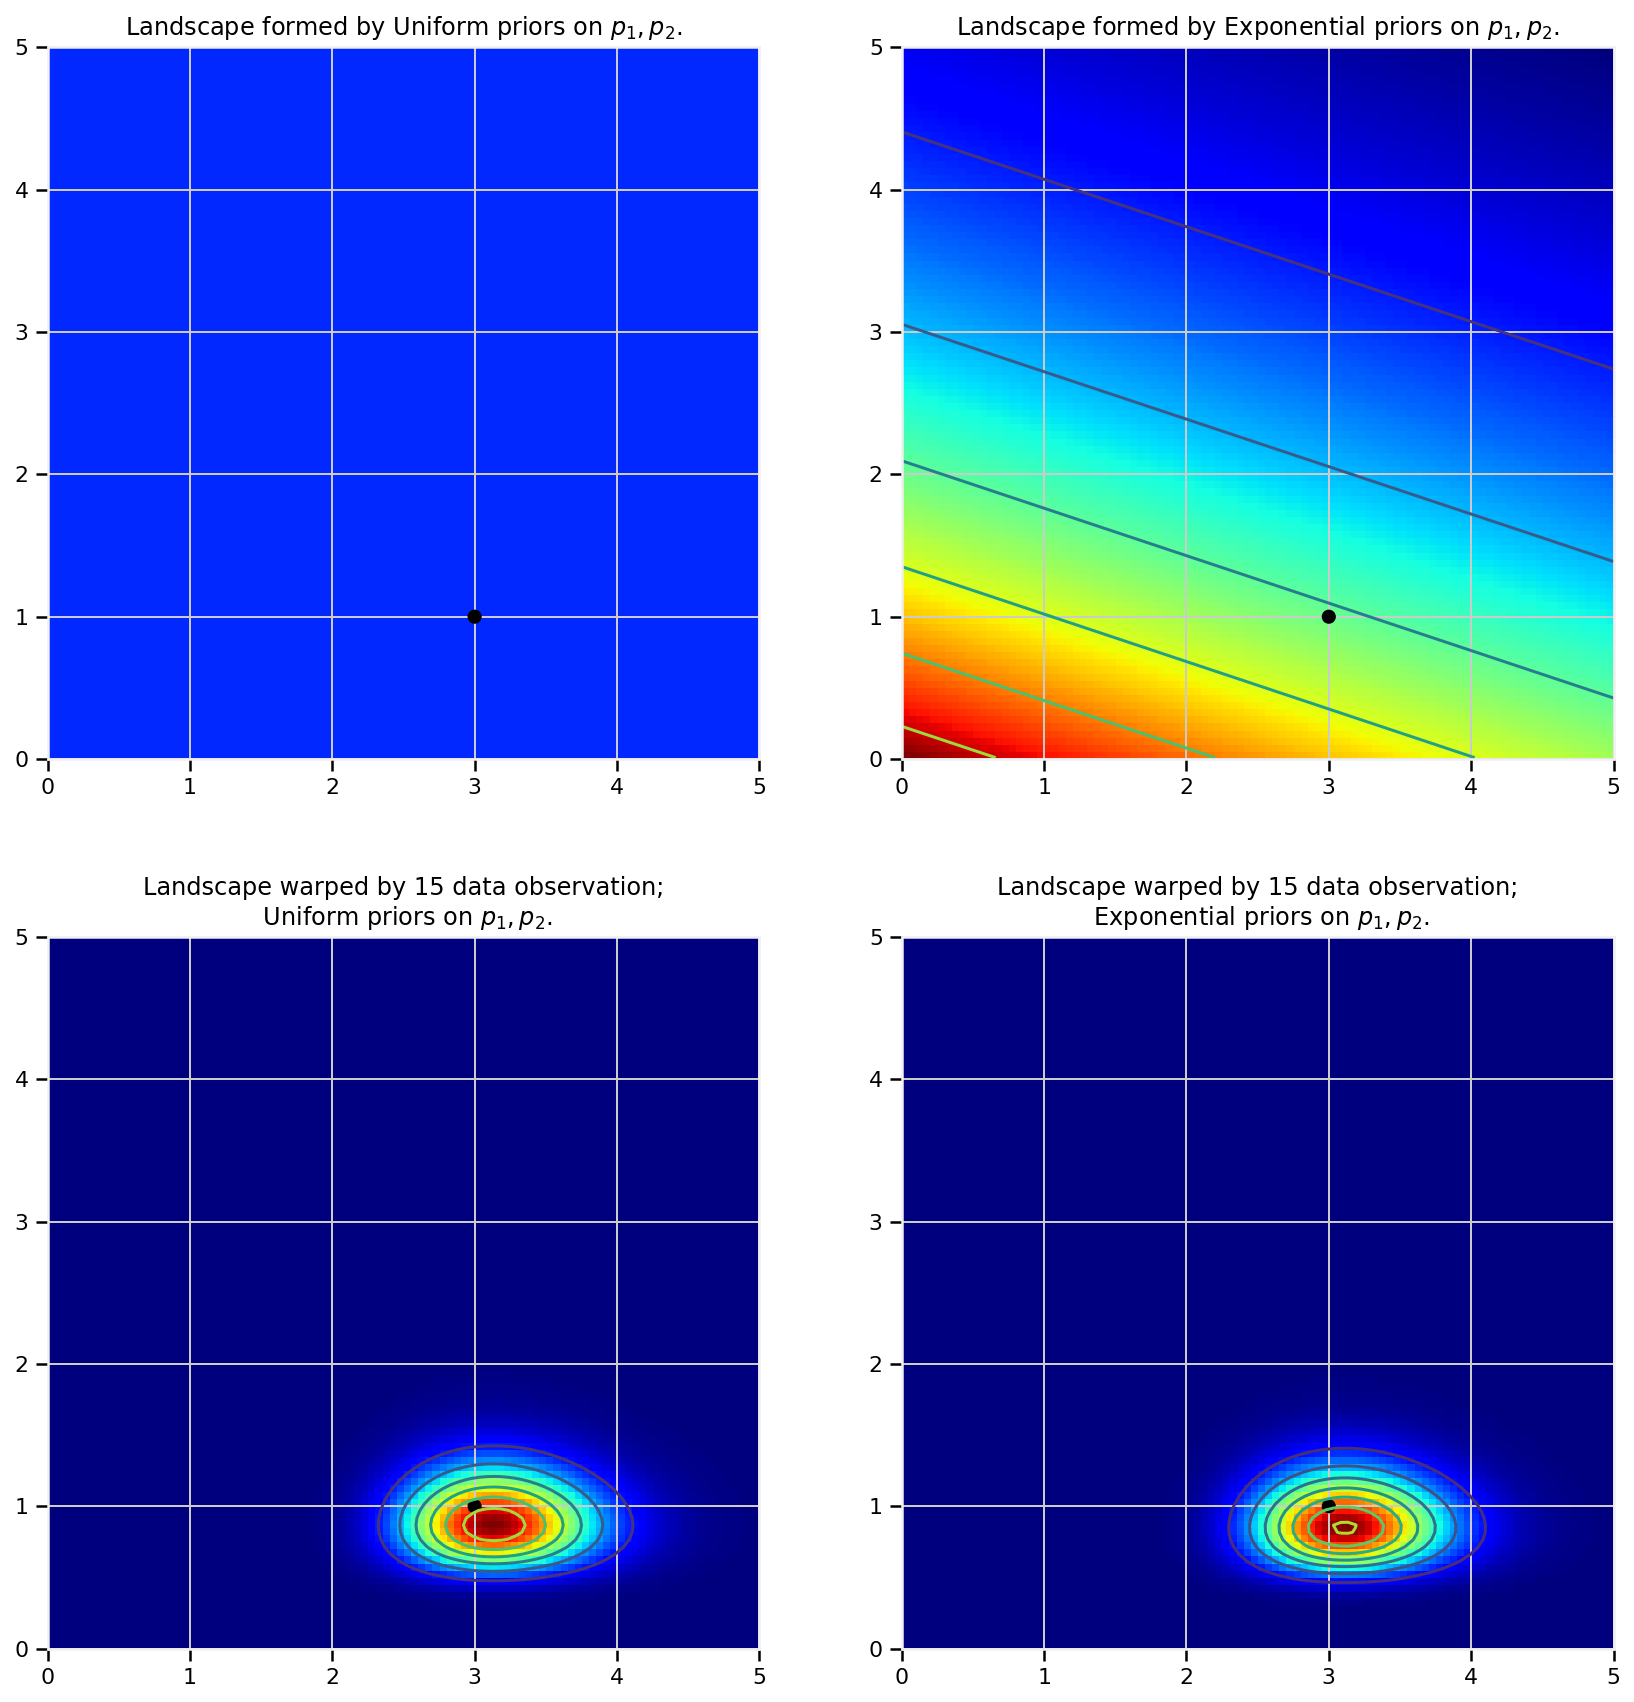

In [24]:
plt.figure(figsize(12.5, 15.0))
# matplotlib heavy lifting below, beware!

# SUBPLOT for regular Uniform
uni_x_ = evaluate(tfd.Uniform(low=0., high=5.).prob(tf.cast(x_,dtype=tf.float32)))
m = np.median(uni_x_[uni_x_ > 0])
uni_x_[uni_x_ == 0] = m
uni_y_ = evaluate(tfd.Uniform(low=0., high=5.).prob(tf.cast(y_,dtype=tf.float32)))
m = np.median(uni_y_[uni_y_ > 0])
uni_y_[uni_y_ == 0] = m

M_ = evaluate(tf.matmul(tf.expand_dims(uni_x_, 1), tf.expand_dims(uni_y_, 0)))
plt.subplot(221)
plot_contour(M_, x_, y_, lambda_1_true, lambda_2_true, 
             title=r"Landscape formed by Uniform priors on $p_1, p_2$.",
             vmax=1, vmin=-.15)

# SUBPLOT for Uniform + Data point
plt.subplot(223)
plot_contour(M_ * L_, x_, y_, lambda_1_true, lambda_2_true,
             title="Landscape warped by %d data observation;\n Uniform priors on $p_1, p_2$." % N)

# SUBPLOT for regular Exponential
plt.subplot(222)
exp_x_ = evaluate(tfd.Exponential(rate=.3).prob(tf.to_float(x_)))
exp_x_[np.isnan(exp_x_)] = exp_x_[1]
exp_y_ = evaluate(tfd.Exponential(rate=.10).prob(tf.to_float(y_)))
exp_y_[np.isnan(exp_y_)] = exp_y_[1]
M_ = evaluate(tf.matmul(tf.expand_dims(exp_x_, 1), tf.expand_dims(exp_y_, 0)))
plot_contour(M_, x_, y_, lambda_1_true, lambda_2_true,
             title="Landscape formed by Exponential priors on $p_1, p_2$.")


# SUBPLOT for Exponential + Data point
plt.subplot(224)
# This is the likelihood times prior, that results in the posterior.
plot_contour(M_ * L_, x_, y_, lambda_1_true, lambda_2_true)
plt.title("Landscape warped by %d data observation;\n Exponential priors on \
$p_1, p_2$." % N);

The plot on the left is the deformed landscape with the $\text{Uniform}(0,5)$ priors, and the plot on the right is the deformed landscape with the exponential priors. Notice that the posterior landscapes look different from one another, though the data observed is identical in both cases. The reason is as follows. Notice the exponential-prior landscape, top right figure, puts very little posterior weight on values in the upper right corner of the figure: this is because the prior does not put much weight there. On the other hand, the uniform-prior landscape is happy to put posterior weight in the upper-right corner, as the prior puts more weight there.

Notice also the highest-point, corresponding the the darkest red, is biased towards (0,0) in the exponential case, which is the result from the exponential prior putting more prior weight in the (0,0) corner.

The black dot represents the true parameters. Even with 1 sample point, the mountains attempts to contain the true parameter. Of course, inference with a sample size of 1 is incredibly naive, and choosing such a small sample size was only illustrative.

It's a great exercise to try changing the sample size to other values (try 2, 5, 10, 100?...) and observing how our "mountain" posterior changes.

## Exploring the landscape using the MCMC
We should explore the deformed posterior space generated by our prior surface and observed data to find the posterior mountain. However, we cannot naively search the space: any computer scientist will tell you that traversing $N$-dimensional space is exponentially difficult in $N$: the size of the space quickly blows-up as we increase $N$ (see the curse of dimensionality). What hope do we have to find these hidden mountains? The idea behind MCMC is to perform an intelligent search of the space. To say "search" implies we are looking for a particular point, which is perhaps not an accurate as we are really looking for a broad mountain.

Recall that MCMC returns samples from the posterior distribution, not the distribution itself. Stretching our mountainous analogy to its limit, MCMC performs a task similar to repeatedly asking "How likely is this pebble I found to be from the mountain I am searching for?", and completes its task by returning thousands of accepted pebbles in hopes of reconstructing the original mountain.

When I say MCMC intelligently searches, I really am saying MCMC will hopefully converge towards the areas of high posterior probability. MCMC does this by exploring nearby positions and moving into areas with higher probability. Again, perhaps "converge" is not an accurate term to describe MCMC's progression. Converging usually implies moving towards a point in space, but MCMC moves towards a broader area in the space and randomly walks in that area, picking up samples from that area.

### Why Thousands of Samples?
At first, returning thousands of samples to the user might sound like being an inefficient way to describe the posterior distributions. I would argue that this is extremely efficient. Consider the alternative possibilities:

1. Returning a mathematical formula for the "mountain ranges" would involve describing a N-dimensional surface with arbitrary peaks and valleys.
2. Returning the "peak" of the landscape, while mathematically possible and a sensible thing to do as the highest point corresponds to most probable estimate of the unknowns, ignores the shape of the landscape, which we have previously argued is very important in determining posterior confidence in unknowns.
Besides computational reasons, likely the strongest reason for returning samples is that we can easily use The Law of Large Numbers to solve otherwise intractable problems. I postpone this discussion for the next chapter. With the thousands of samples, we can reconstruct the posterior surface by organizing them in a histogram.



### Algorithms to perform MCMC
There is a large family of algorithms that perform MCMC. Most of these algorithms can be expressed at a high level as follows: (Mathematical details can be found in the appendix.)

1. Start at current position.
2. Propose moving to a new position (investigate a pebble near you).
3. Accept/Reject the new position based on the position's adherence to the data and prior distributions (ask if the pebble likely came from the mountain).
4. 
    * A) If you accept: Move to the new position. Return to Step 1.
    * B) Else: Do not move to new position. Return to Step 1.
5. After a large number of iterations, return all accepted positions.

This way we move in the general direction towards the regions where the posterior distributions exist, and collect samples sparingly on the journey. Once we reach the posterior distribution, we can easily collect samples as they likely all belong to the posterior distribution.

If the current position of the MCMC algorithm is in an area of extremely low probability, which is often the case when the algorithm begins (typically at a random location in the space), the algorithm will move in positions that are likely not from the posterior but better than everything else nearby. Thus the first moves of the algorithm are not reflective of the posterior.

In the above algorithm's pseudocode, notice that only the current position matters (new positions are investigated only near the current position). We can describe this property as memorylessness, i.e. the algorithm does not care how it arrived at its current position, only that it is there.

Other approximation solutions to the posterior
Besides MCMC, there are other procedures available for determining the posterior distributions. A Laplace approximation is an approximation of the posterior using simple functions. A more advanced method is Variational Bayes. All three methods, Laplace Approximations, Variational Bayes, and classical MCMC have their pros and cons. We will only focus on MCMC in this book.



### Example: Unsupervised Clustering using a Mixture Model

In [55]:
reset_sess()

import wget 
url = 'https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter3_MCMC/data/mixture_data.csv'
filename = wget.download(url)
filename

'mixture_data (1).csv'

[115.85679142 152.26153716 178.87449059 162.93500815 107.02820697
 105.19141146 118.38288501 125.3769803  102.88054011 206.71326136] ...


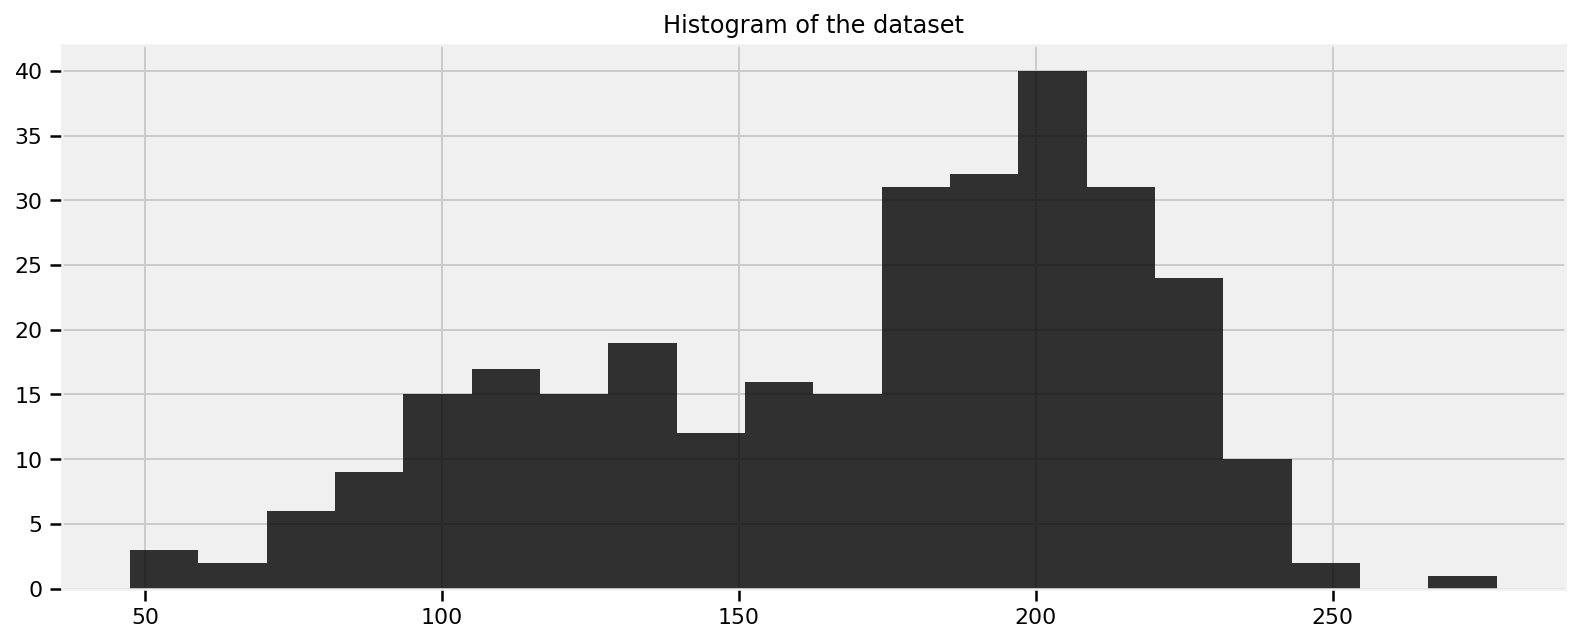

In [56]:
plt.figure(figsize=(12, 5))
data_ = np.loadtxt('mixture_data.csv', delimiter=',')
plt.hist(data_, bins=20, color='k', histtype='stepfilled', alpha=0.8)
plt.title('Histogram of the dataset')
plt.ylim([0, None]);
print(data_[:10], '...')

In [57]:
p1 = tfd.Uniform(name='p', low=0., high=1.).sample()
p2 = 1 - p1
p = tf.stack([p1, p2])

rv_assignment = tfd.Categorical(name="assignment",probs=p) 
assignment = rv_assignment.sample(sample_shape=data_.shape[0])

[
    p_,
    assignment_
] = evaluate([
    p,
    assignment
])

print("prior assignment, with p = %.2f:" % p_[0])
print (assignment_[:10])

prior assignment, with p = 0.59:
[0 1 0 1 0 0 0 1 0 0]


In [58]:
rv_sds = tfd.Uniform(name="rv_sds", low=[0., 0.], high=[100., 100.])
print (str(rv_sds))

rv_centers = tfd.Normal(name="rv_centers", loc=[120., 190.], scale=[10., 10.])
    
sds = rv_sds.sample()
print ("shape of sds sample:",sds.shape)
centers = rv_centers.sample()

rv_assignments = tfd.Categorical(probs=tf.stack([0.4, 0.6]))
assignments = rv_assignments.sample(sample_shape=10)

# and to combine it with the observations:
rv_observations = tfd.MixtureSameFamily(
    mixture_distribution=rv_assignments,
    components_distribution=tfd.Normal(
        loc=centers,
        scale=sds))

observations = rv_observations.sample(sample_shape=10)

[    
    assignments_,
    observations_,
    sds_,
    centers_
] = evaluate([
    assignments,
    observations,
    sds,
    centers
])

print("simulated data: ", observations_[:4], "...")
print("Random assignments: ", assignments_[:4], "...")
print("Assigned center: ", centers_[:4], "...")
print("Assigned standard deviation: ", sds_[:4],"...")

tfp.distributions.Uniform("rv_sds/", batch_shape=[2], event_shape=[], dtype=float32)
shape of sds sample: (2,)
simulated data:  [206.09882   15.778793 202.7038   169.47108 ] ...
Random assignments:  [1 0 1 1] ...
Assigned center:  [125.07043 191.42885] ...
Assigned standard deviation:  [42.39757  59.914673] ...


In [59]:
def joint_log_prob(data_, sample_prob_1, sample_centers, sample_sds):
    """
    Joint log probability optimization function.
        
    Args:
      data: tensor array representation of original data
      sample_prob_1: Scalar representing probability (out of 1.0) of assignment 
        being 0
      sample_sds: 2d vector containing standard deviations for both normal dists
        in model
      sample_centers: 2d vector containing centers for both normal dists in model
    Returns: 
      Joint log probability optimization function.
    """  
    ### Create a mixture of two scalar Gaussians:
    rv_prob = tfd.Uniform(name='rv_prob', low=0., high=1.)
    sample_prob_2 = 1. - sample_prob_1
    rv_assignments = tfd.Categorical(probs=tf.stack([sample_prob_1, sample_prob_2]))
    
    rv_sds = tfd.Uniform(name="rv_sds", low=[0., 0.], high=[100., 100.])
    rv_centers = tfd.Normal(name="rv_centers", loc=[120., 190.], scale=[10., 10.])
    
    rv_observations = tfd.MixtureSameFamily(
        mixture_distribution=rv_assignments,
        components_distribution=tfd.Normal(
          loc=sample_centers,       # One for each component.
          scale=sample_sds))        # And same here.
    return (
        rv_prob.log_prob(sample_prob_1)
        + rv_prob.log_prob(sample_prob_2)
        + tf.reduce_sum(rv_observations.log_prob(data_))      # Sum over samples.
        + tf.reduce_sum(rv_centers.log_prob(sample_centers)) # Sum over components.
        + tf.reduce_sum(rv_sds.log_prob(sample_sds))         # Sum over components.
    )

In [60]:
number_of_steps=25000 #@param {type:"slider", min:0, max:50000, step:1000}
burnin=1000 #@param {type:"slider", min:0, max:2000, step:100}
num_leapfrog_steps=3

# Set the chain's start state.
initial_chain_state = [
    tf.constant(0.5, name='init_probs'),
    tf.constant([120., 190.], name='init_centers'),
    tf.constant([10., 10.], name='init_sds')
]

# Since MCMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfp.bijectors.Identity(),       # Maps R to R.
    tfp.bijectors.Identity(),       # Maps R to R.
    tfp.bijectors.Identity(),       # Maps R to R.
]

# Define a closure over our joint_log_prob.
unnormalized_posterior_log_prob = lambda *args: joint_log_prob(data_, *args)


# Initialize the step_size. (It will be automatically adapted.)
with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE):
    step_size = tf.get_variable(
        name='step_size',
        initializer=tf.constant(0.5, dtype=tf.float32),
        trainable=False,
        use_resource=True
    )

# Defining the HMC
hmc=tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        num_leapfrog_steps=num_leapfrog_steps,
        step_size=step_size,
        step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(num_adaptation_steps=int(burnin * 0.8)),
        state_gradients_are_stopped=True),
    bijector=unconstraining_bijectors)

# Sample from the chain.
[
    posterior_prob,
    posterior_centers,
    posterior_sds
], kernel_results = tfp.mcmc.sample_chain(
    num_results=number_of_steps,
    num_burnin_steps=burnin,
    current_state=initial_chain_state,
    kernel=hmc)

# Initialize any created variables.
init_g = tf.global_variables_initializer()
init_l = tf.local_variables_initializer()

In [61]:
evaluate(init_g)
evaluate(init_l)
[
    posterior_prob_,
    posterior_centers_,
    posterior_sds_,
    kernel_results_
] = evaluate([
    posterior_prob,
    posterior_centers,
    posterior_sds,
    kernel_results
])
    
new_step_size_initializer_ = kernel_results_.inner_results.is_accepted.mean()
print("acceptance rate: {}".format(
    new_step_size_initializer_))
new_step_size_initializer_
print("final step size: {}".format(
    kernel_results_.inner_results.extra.step_size_assign[-100:].mean()))

acceptance rate: 0.80208
final step size: 0.052764225751161575


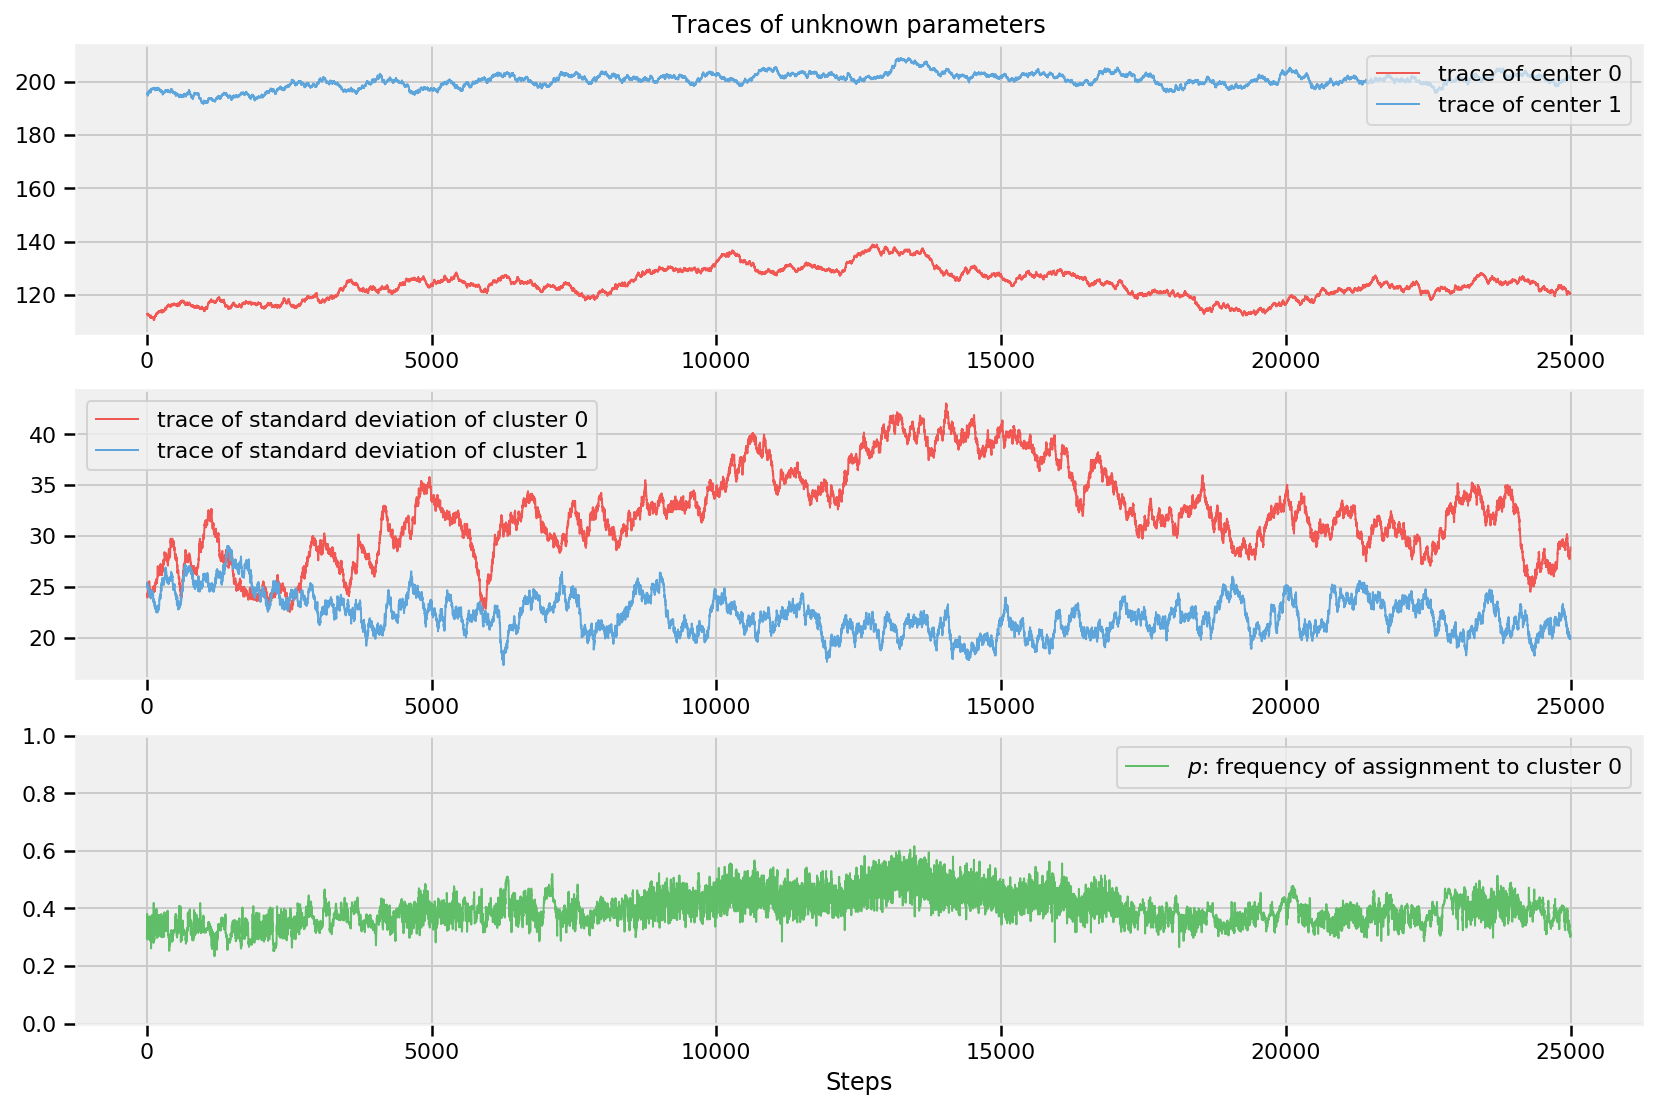

In [62]:
plt.figure(figsize(12.5, 9))
plt.subplot(311)
lw = 1
center_trace = posterior_centers_

# for pretty colors later in the book.
colors = [TFColor[3], TFColor[0]] if center_trace[-1, 0] > center_trace[-1, 1] \
    else [TFColor[0], TFColor[3]]

plt.plot(center_trace[:, 0], label="trace of center 0", c=colors[0], lw=lw)
plt.plot(center_trace[:, 1], label="trace of center 1", c=colors[1], lw=lw)
plt.title("Traces of unknown parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.7)

plt.subplot(312)
std_trace = posterior_sds_
plt.plot(std_trace[:, 0], label="trace of standard deviation of cluster 0",
     c=colors[0], lw=lw)
plt.plot(std_trace[:, 1], label="trace of standard deviation of cluster 1",
     c=colors[1], lw=lw)
plt.legend(loc="upper left")

plt.subplot(313)
p_trace = posterior_prob_
plt.plot(p_trace, label="$p$: frequency of assignment to cluster 0",
     color=TFColor[2], lw=lw)
plt.xlabel("Steps")
plt.ylim(0, 1)
plt.legend();

Notice the following characteristics:

1. The traces converge, not to a single point, but to a distribution of possible points. This is convergence in an MCMC algorithm.
2. Inference using the first few thousand points is a bad idea, as they are unrelated to the final distribution we are interested in. Thus is it a good idea to discard those samples before using the samples for inference. We call this period before converge the burn-in period.
3. The traces appear as a random "walk" around the space, that is, the paths exhibit correlation with previous positions. This is both good and bad. We will always have correlation between current positions and the previous positions, but too much of it means we are not exploring the space well. This will be detailed in the Diagnostics section later in this chapter.

To achieve further convergence, we will perform more MCMC steps. In the pseudo-code algorithm of MCMC above, the only position that matters is the current position (new positions are investigated near the current position). To continue where we left off, we pass the current values of the unknown parameters into the `initial_chain_state()` variable. The values that we have already calculated will not be overwritten. This ensures that our sampling continues where it left off in the same way that it left off.

We will sample the MCMC fifty thousand more times and visualize the progress below:

In [63]:
number_of_steps=50000 #@param {type:"slider", min:0, max:50000, step:1000}
burnin=10000 #@param {type:"slider", min:0, max:2000, step:100}

# Set the chain's start state.
initial_chain_state = [
    tf.constant(posterior_prob_[-1], name='init_probs_2'),
    tf.constant(posterior_centers_[-1], name='init_centers_2'),
    tf.constant(posterior_sds_[-1], name='init_sds_2')
]


# Initialize the step_size. (It will be automatically adapted.)
with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE):
    step_size = tf.get_variable(
        name='step_size_2',
        #initializer=tf.constant(new_step_size_initializer_, dtype=tf.float32),
        initializer=tf.constant(0.5, dtype=tf.float32),
        trainable=False,
        use_resource=True
    )
    step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(num_adaptation_steps=int(burnin * 0.8))

# Defining the HMC
hmc=tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        num_leapfrog_steps=num_leapfrog_steps,
        step_size=step_size,
        step_size_update_fn=step_size_update_fn,
        state_gradients_are_stopped=True),
    bijector=unconstraining_bijectors)

# Sample from the chain.
[
    posterior_prob_2,
    posterior_centers_2,
    posterior_sds_2
], kernel_results = tfp.mcmc.sample_chain(
    num_results=number_of_steps,
    num_burnin_steps=burnin,
    current_state=initial_chain_state,
    kernel=hmc)


# Initialize any created variables.
init_g = tf.global_variables_initializer()
init_l = tf.local_variables_initializer()

evaluate(init_g)
evaluate(init_l)
[
    posterior_prob_2_,
    posterior_centers_2_,
    posterior_sds_2_,
    kernel_results_
] = evaluate([
    posterior_prob_2,
    posterior_centers_2,
    posterior_sds_2,
    kernel_results
])

print("acceptance rate: {}".format(
    kernel_results_.inner_results.is_accepted.mean()))
new_step_size_initializer_
print("final step size: {}".format(
    kernel_results_.inner_results.extra.step_size_assign[-100:].mean()))


acceptance rate: 0.35944
final step size: 0.05945603922009468


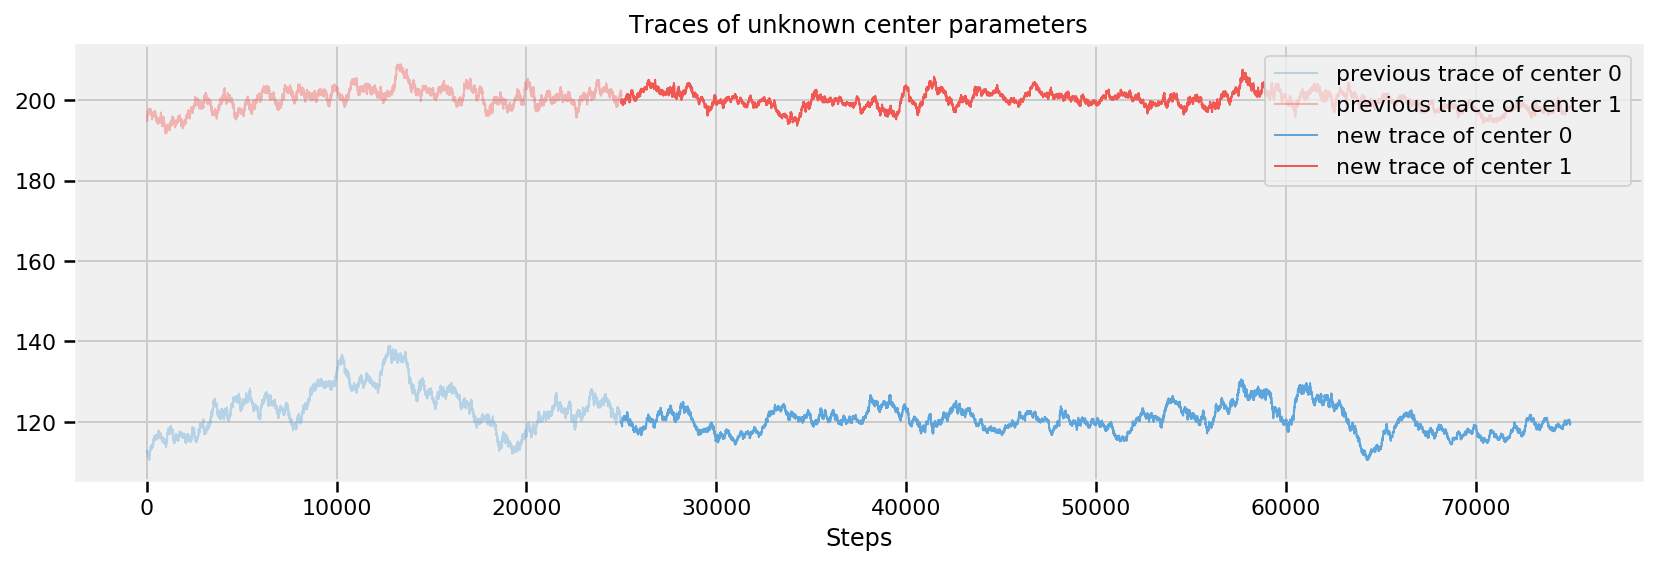

In [64]:
plt.figure(figsize(12.5, 4))
center_trace = posterior_centers_2_
prev_center_trace = posterior_centers_

x = np.arange(25000)
plt.plot(x, prev_center_trace[:, 0], label="previous trace of center 0",
      lw=lw, alpha=0.4, c=colors[1])
plt.plot(x, prev_center_trace[:, 1], label="previous trace of center 1",
      lw=lw, alpha=0.4, c=colors[0])

x = np.arange(25000, 75000)
plt.plot(x, center_trace[:, 0], label="new trace of center 0", lw=lw, c="#5DA5DA")
plt.plot(x, center_trace[:, 1], label="new trace of center 1", lw=lw, c="#F15854")

plt.title("Traces of unknown center parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.8)
plt.xlabel("Steps");

### Cluster Investigation
We have not forgotten our main challenge: identify the clusters. We have determined posterior distributions for our unknowns. We plot the posterior distributions of the center and standard deviation variables below:

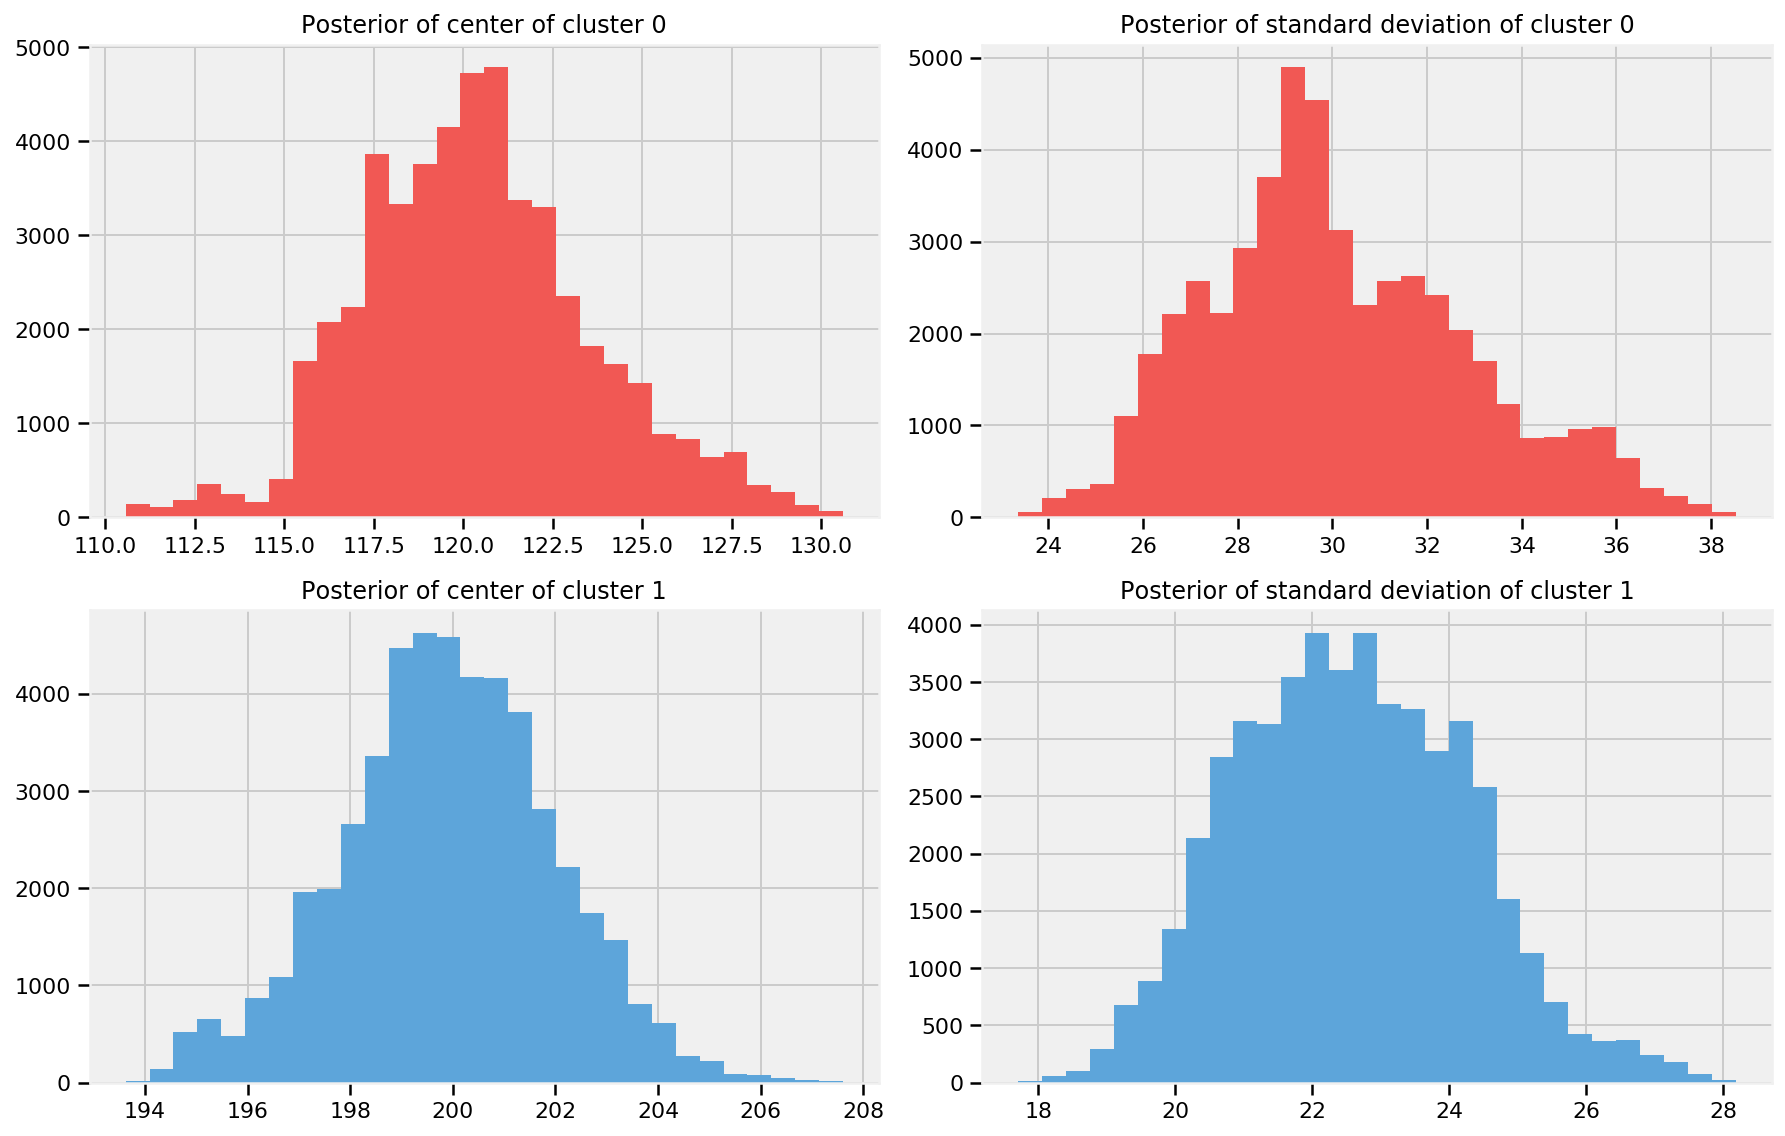

In [65]:
plt.figure(figsize(12.5, 8))
std_trace = posterior_sds_2_
prev_std_trace = posterior_sds_

_i = [1, 2, 3, 4]
for i in range(2):
    plt.subplot(2, 2, _i[2 * i])
    plt.title("Posterior of center of cluster %d" % i)
    plt.hist(center_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")

    plt.subplot(2, 2, _i[2 * i + 1])
    plt.title("Posterior of standard deviation of cluster %d" % i)
    plt.hist(std_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")
    # plt.autoscale(tight=True)

plt.tight_layout()

The MCMC algorithm has proposed that the most likely centers of the two clusters are near 120 and 200 respectively. Similar inference can be applied to the standard deviation.

In the PyMC3 version of this chapter, we depict the posterior distributions for the labels each data point.However, in our TFP version, since our model marginalized out the assignment variable, we don't have traces for that variable from the MCMC.

As a substitute, below we can generate a posterior predictive distribution over the assignments, and then generate some samples from it.

Below is a visualization of this. The y-axis represents our samples from the posterior predictive distribution. The x-axis are the sorted values of the original data points. A red square is an assignment to cluster 0, and a blue square is an assignment to cluster 1.

In [66]:
# put the data into a tensor
data = tf.constant(data_,dtype=tf.float32)
data = data[:,tf.newaxis]

# This produces a cluster per MCMC chain
rv_clusters_1 = tfd.Normal(posterior_centers_2_[:, 0], posterior_sds_2_[:, 0])
rv_clusters_2 = tfd.Normal(posterior_centers_2_[:, 1], posterior_sds_2_[:, 1])

# Compute the un-normalized log probabilities for each cluster
cluster_1_log_prob = rv_clusters_1.log_prob(data) + tf.math.log(posterior_prob_2_)
cluster_2_log_prob = rv_clusters_2.log_prob(data) + tf.math.log(1. - posterior_prob_2_)

x = tf.stack([cluster_1_log_prob, cluster_2_log_prob],axis=-1)
y = tf.math.reduce_logsumexp(x,-1)

# Bayes rule to compute the assignment probability: P(cluster = 1 | data) ∝ P(data | cluster = 1) P(cluster = 1)
log_p_assign_1 = cluster_1_log_prob - tf.math.reduce_logsumexp(tf.stack([cluster_1_log_prob, cluster_2_log_prob], axis=-1), -1)

# Average across the MCMC chain
log_p_assign_1 = tf.math.reduce_logsumexp(log_p_assign_1, -1) - tf.math.log(tf.cast(log_p_assign_1.shape[-1], tf.float32))
 
p_assign_1 = tf.exp(log_p_assign_1)
p_assign = tf.stack([p_assign_1,1-p_assign_1],axis=-1)

# for charting 
probs_assignments = p_assign_1

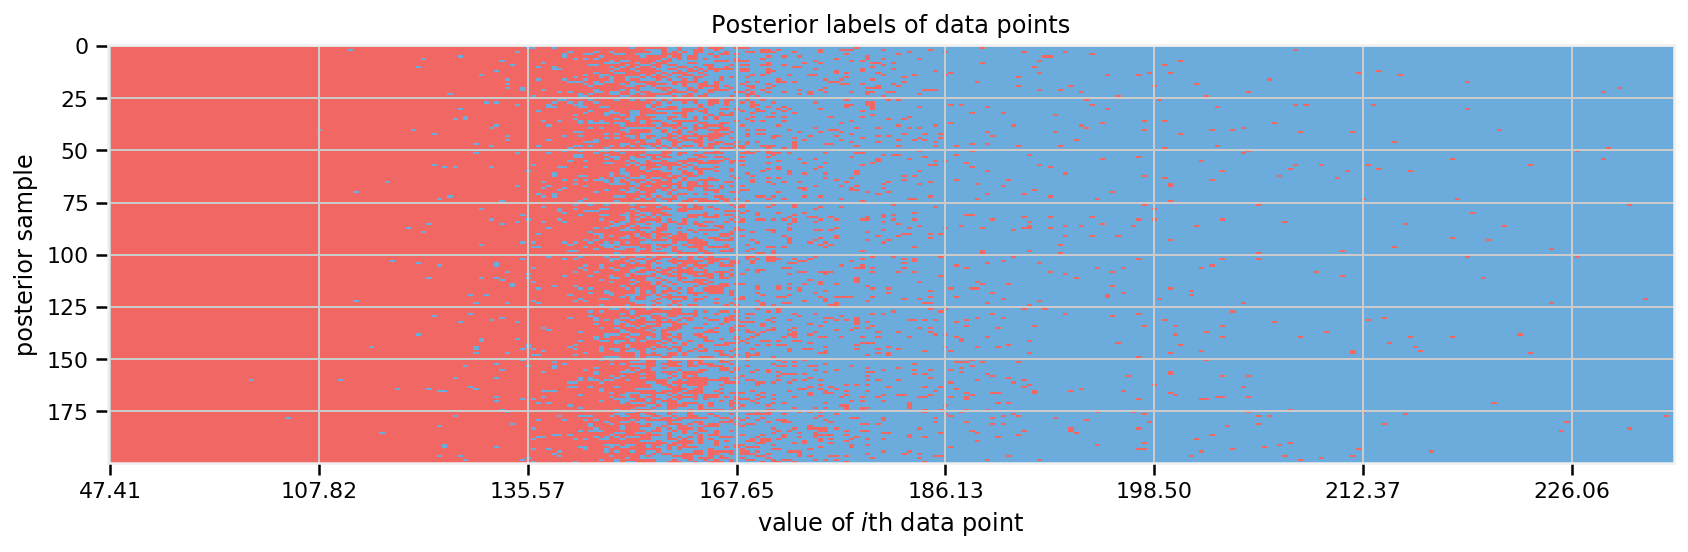

In [69]:
burned_assignment_trace_ = evaluate(tfd.Categorical(probs=p_assign).sample(sample_shape=200))
plt.figure(figsize(12.5, 5))
plt.cmap = mpl.colors.ListedColormap(colors)
plt.imshow(burned_assignment_trace_[:, np.argsort(data_)],
       cmap=plt.cmap, aspect=.4, alpha=.9)
plt.xticks(np.arange(0, data_.shape[0], 40),
       ["%.2f" % s for s in np.sort(data_)[::40]])
plt.ylabel("posterior sample")
plt.xlabel("value of $i$th data point")
plt.title("Posterior labels of data points");

Looking at the above plot, it appears that the most uncertainty is between 150 and 170. The above plot slightly misrepresents things, as the x-axis is not a true scale (it displays the value of the $i$th sorted data point.) A more clear diagram is below, where we have estimated the frequency of each data point belonging to the labels 0 and 1.

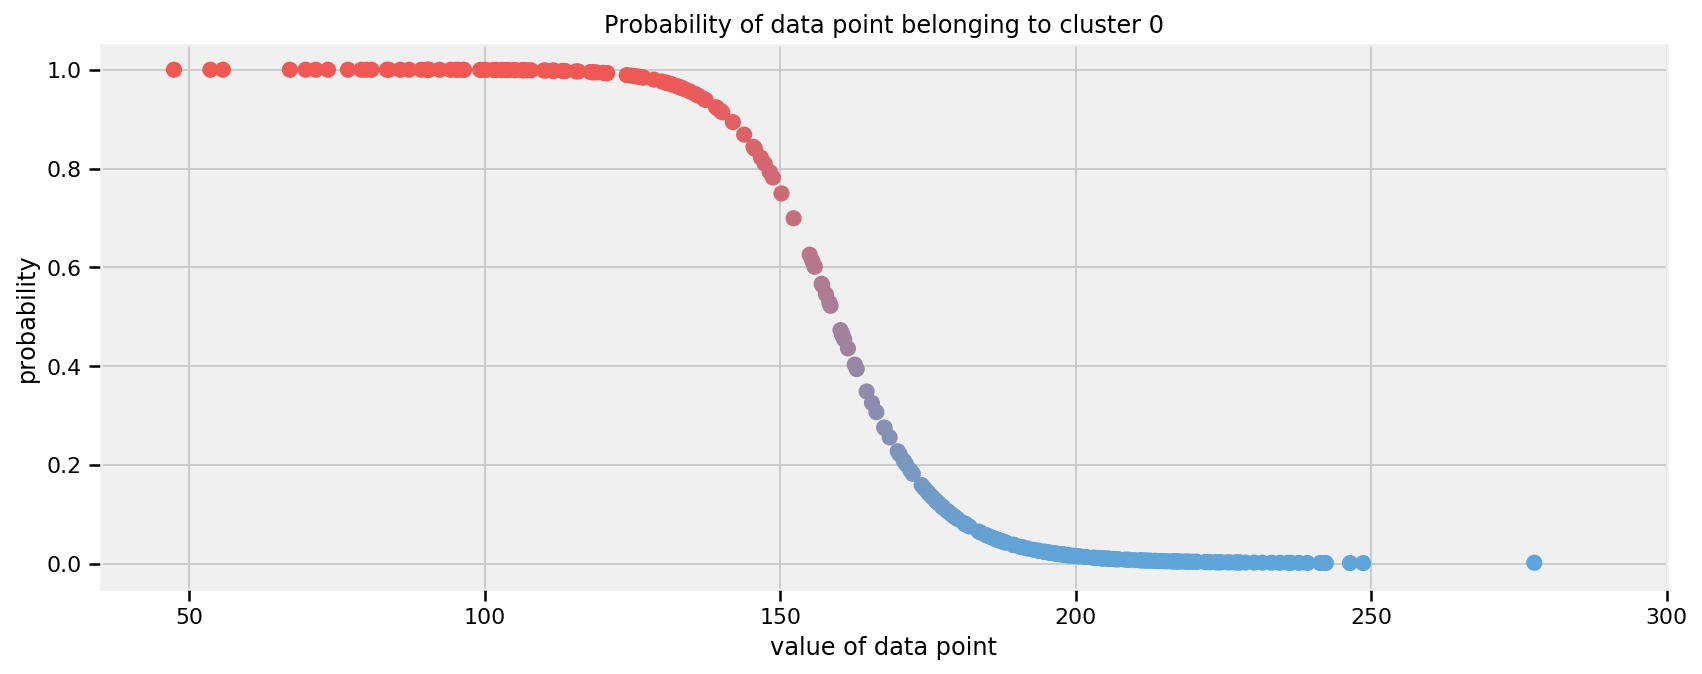

In [70]:
plt.figure(figsize(12.5, 5))

cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", colors)
assign_trace = evaluate(probs_assignments)[np.argsort(data_)]
plt.scatter(data_[np.argsort(data_)], assign_trace, cmap=cmap,
        c=(1 - assign_trace), s=50)
plt.ylim(-0.05, 1.05)
plt.xlim(35, 300)
plt.title("Probability of data point belonging to cluster 0")
plt.ylabel("probability")
plt.xlabel("value of data point");

Even though we modeled the clusters using Normal distributions, we didn't get just a single Normal distribution that best fits the data (whatever our definition of best is), but a distribution of values for the Normal's parameters. How can we choose just a single pair of values for the mean and variance and determine a sorta-best-fit gaussian?

One quick and dirty way (which has nice theoretical properties we will see in Chapter 5), is to use the mean of the posterior distributions. Below we overlay the Normal density functions, using the mean of the posterior distributions as the chosen parameters, with our observed data:

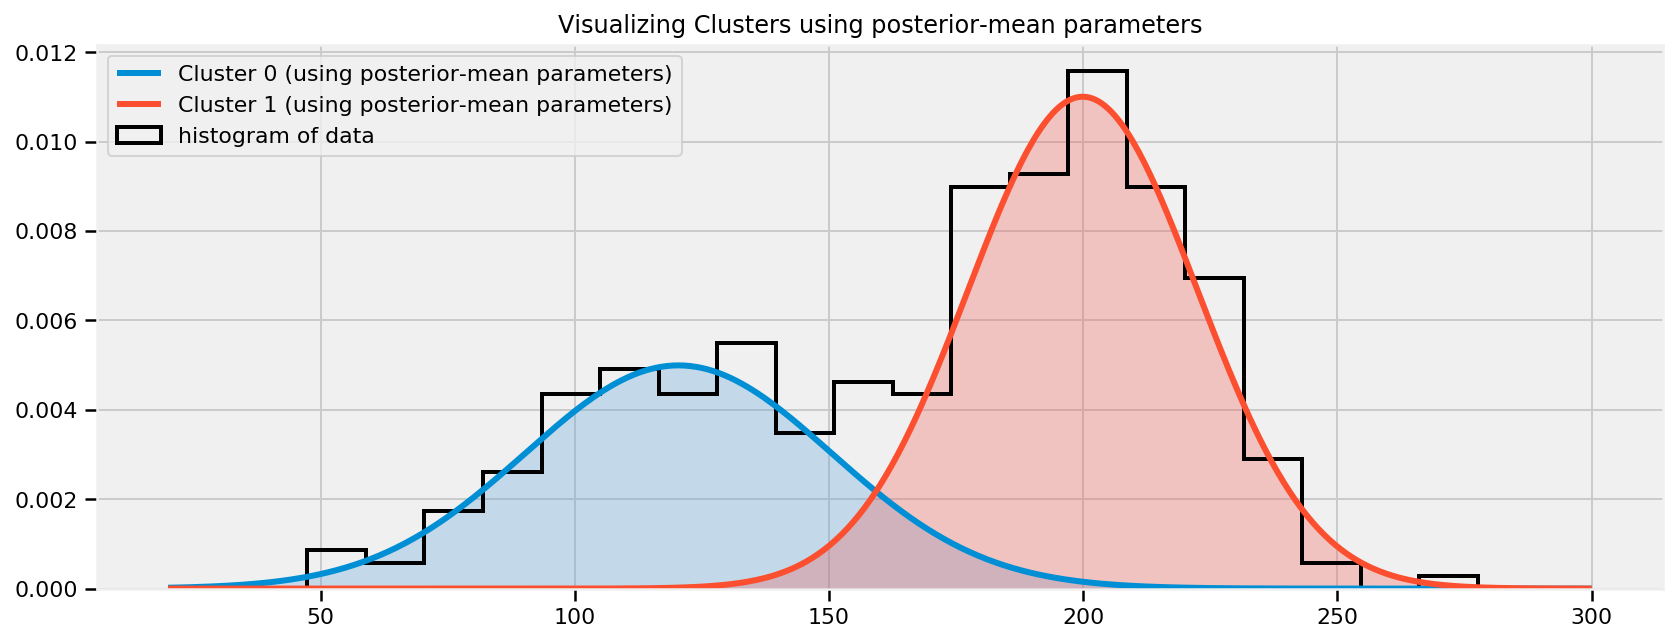

In [71]:
x_ = np.linspace(20, 300, 500)
posterior_center_means_ = evaluate(tf.reduce_mean(posterior_centers_2_, axis=0))
posterior_std_means_ = evaluate(tf.reduce_mean(posterior_sds_2_, axis=0))
posterior_prob_mean_ = evaluate(tf.reduce_mean(posterior_prob_2_, axis=0))

plt.hist(data_, bins=20, histtype="step", density=True, color="k",
     lw=2, label="histogram of data")
y_ = posterior_prob_mean_ * evaluate(tfd.Normal(loc=posterior_center_means_[0],
                                scale=posterior_std_means_[0]).prob(x_))
plt.plot(x_, y_, label="Cluster 0 (using posterior-mean parameters)", lw=3)
plt.fill_between(x_, y_, color=colors[1], alpha=0.3)

y_ = (1 - posterior_prob_mean_) * evaluate(tfd.Normal(loc=posterior_center_means_[1],
                                      scale=posterior_std_means_[1]).prob(x_))
plt.plot(x_, y_, label="Cluster 1 (using posterior-mean parameters)", lw=3)
plt.fill_between(x_, y_, color=colors[0], alpha=0.3)

plt.legend(loc="upper left")
plt.title("Visualizing Clusters using posterior-mean parameters");

### Returning to Clustering: Prediction
The above clustering can be generalized to $k$ clusters. Choosing $k=2$ allowed us to visualize the MCMC better, and examine some very interesting plots.

What about prediction? Suppose we observe a new data point, say $x = 175$, and we wish to label it to a cluster. It is foolish to simply assign it to the closer cluster center, as this ignores the standard deviation of the clusters, and we have seen from the plots above that this consideration is very important. More formally: we are interested in the probability (as we cannot be certain about labels) of assigning $x=175$ to cluster 1. Denote the assignment of $x$ as $L_x$, which is equal to 0 or 1, and we are interested in $P(L_x = 1 \;|\; x = 175 )$.

A naive method to compute this is to re-run the above MCMC with the additional data point appended. The disadvantage with this method is that it will be slow to infer for each novel data point. Alternatively, we can try a less precise, but much quicker method.

We will use Bayes Theorem for this. If you recall, Bayes Theorem looks like:

$$ P( A | X ) = \frac{ P( X  | A )P(A) }{P(X) }$$
In our case, $A$ represents $L_x = 1$ and $X$ is the evidence we have: we observe that $x = 175$. For a particular sample set of parameters for our posterior distribution, $( \mu_0, \sigma_0, \mu_1, \sigma_1, p)$, we are interested in asking "Is the probability that $x$ is in cluster 1 greater than the probability it is in cluster 0?", where the probability is dependent on the chosen parameters. $$
\begin{align}
&amp; P(L_x = 1| x = 175 ) \gt P(L_x = 0| x = 175 ) \\[5pt]
&amp; \frac{ P( x=175  | L_x = 1  )P( L_x = 1 ) }{P(x = 175) } \gt \frac{ P( x=175  | L_x = 0  )P( L_x = 0 )}{P(x = 175) }
\end{align}
$$ As the denominators are equal, they can be ignored (and good riddance, because computing the quantity $P(x = 175)$ can be difficult).

$$  P( x=175  | L_x = 1  )P( L_x = 1 ) \gt  P( x=175  | L_x = 0  )P( L_x = 0 ) $$

In [72]:
p_trace = posterior_prob_2_[25000:]

x = 175

v = (1 - p_trace) * evaluate(tfd.Normal(loc=center_trace[25000:, 1], 
                                        scale=std_trace[25000:, 1]).log_prob(x)) > \
                                        p_trace * evaluate(tfd.Normal(loc=center_trace[25000:, 0], \
                                        scale=std_trace[25000:, 0]).log_prob(x))
    

print("Probability of belonging to cluster 1:", (v.mean()))

Probability of belonging to cluster 1: 0.03376


Giving us a probability instead of a label is a very useful thing. Instead of the naive

```
L = 1 if prob > 0.5 else 0
```
we can optimize our guesses using a loss function, which the entire fifth chapter is devoted to.

### Diagnosing Convergence
#### Autocorrelation
Autocorrelation is a measure of how related a series of numbers is with itself. A measurement of 1.0 is perfect positive autocorrelation, 0 no autocorrelation, and -1 is perfect negative correlation. If you are familiar with standard correlation, then autocorrelation is just how correlated a series, $x_\tau$, at time $t$ is with the series at time $t-k$:

$$R(k) = \text{Corr}( x_t, x_{t-k} ) $$
For example, consider the two series:

$$x_t \sim \text{Normal}(0,1), \;\; x_0 = 0$$$$y_t \sim \text{Normal}(y_{t-1}, 1 ), \;\; y_0 = 0$$
which have example paths like:

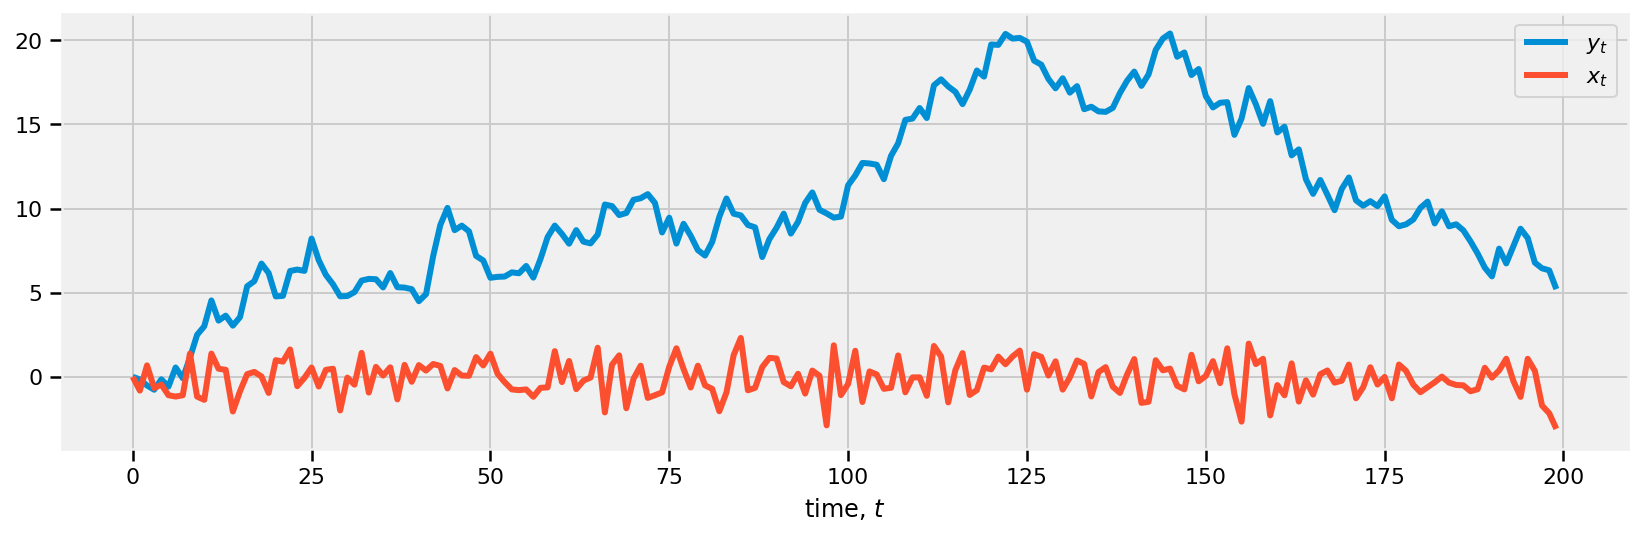

In [73]:
x_t = evaluate(tfd.Normal(loc=0., scale=1.).sample(sample_shape=200))
x_t[0] = 0
y_t = evaluate(tf.zeros(200))
for i in range(1, 200):
    y_t[i] = evaluate(tfd.Normal(loc=y_t[i - 1], scale=1.).sample())

plt.figure(figsize(12.5, 4))
plt.plot(y_t, label="$y_t$", lw=3)
plt.plot(x_t, label="$x_t$", lw=3)
plt.xlabel("time, $t$")
plt.legend();

One way to think of autocorrelation is "If I know the position of the series at time $s$, can it help me know where I am at time $t$?" In the series $x_t$, the answer is No. By construction, $x_t$ are random variables. If I told you that $x_2 = 0.5$, could you give me a better guess about $x_3$? No.

On the other hand, $y_t$ is autocorrelated. By construction, if I knew that $y_2 = 10$, I can be very confident that $y_3$ will not be very far from 10. Similarly, I can even make a (less confident guess) about $y_4$: it will probably not be near 0 or 20, but a value of 5 is not too unlikely. I can make a similar argument about $y_5$, but again, I am less confident. Taking this to it's logical conclusion, we must concede that as $k$, the lag between time points, increases the autocorrelation decreases. We can visualize this:

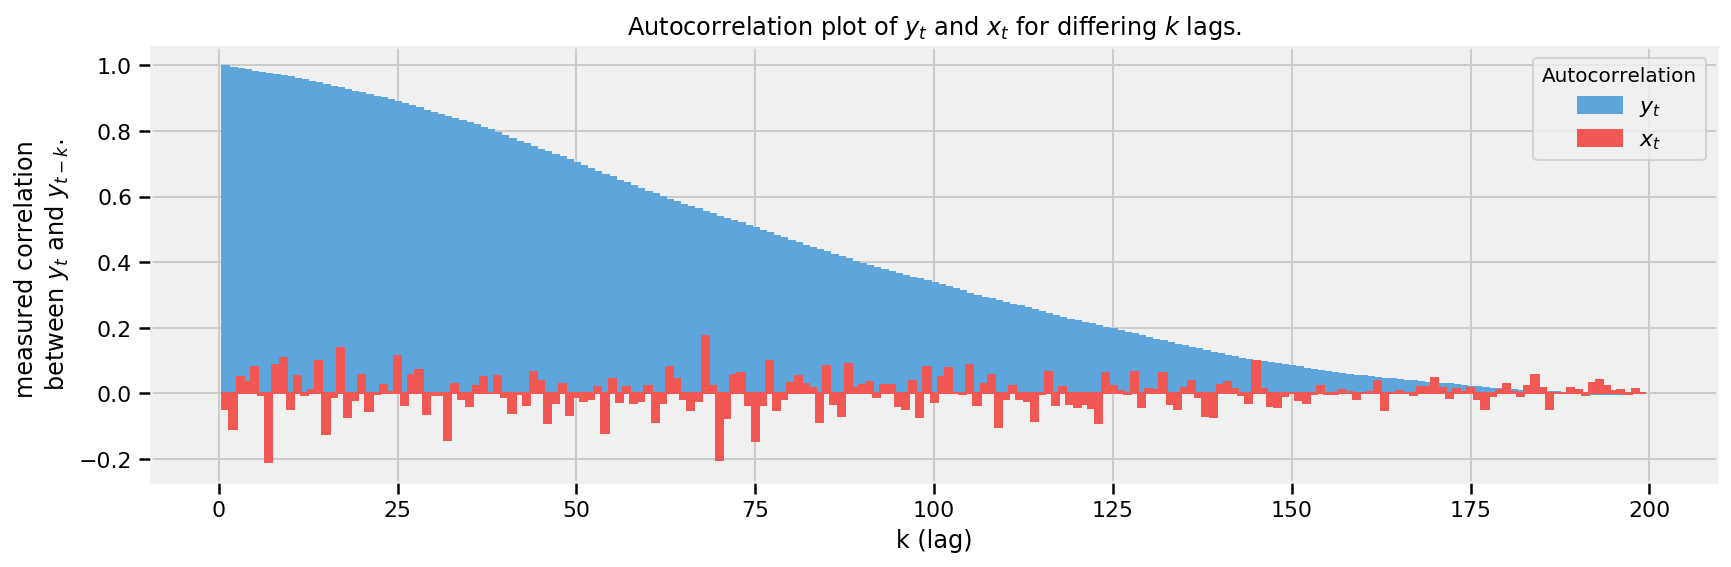

In [74]:
def autocorr(x):
    # from http://tinyurl.com/afz57c4
    result = np.correlate(x, x, mode='full')
    result = result / np.max(result)
    return result[result.size // 2:]

colors = [TFColor[3], TFColor[0], TFColor[6]]

x = np.arange(1, 200)
plt.bar(x, autocorr(y_t)[1:], width=1, label="$y_t$",
        edgecolor=colors[0], color=colors[0])
plt.bar(x, autocorr(x_t)[1:], width=1, label="$x_t$",
        color=colors[1], edgecolor=colors[1])

plt.legend(title="Autocorrelation")
plt.ylabel("measured correlation \nbetween $y_t$ and $y_{t-k}$.")
plt.xlabel("k (lag)")
plt.title("Autocorrelation plot of $y_t$ and $x_t$ for differing $k$ lags.");

Notice that as $k$ increases, the autocorrelation of $y_t$ decreases from a very high point. Compare with the autocorrelation of $x_t$ which looks like noise (which it really is), hence we can conclude no autocorrelation exists in this series.

### How does this relate to MCMC convergence?
By the nature of the MCMC algorithm, we will always be returned samples that exhibit autocorrelation (this is because of the step from your current position, move to a position near you).

A chain that is not exploring the space well will exhibit very high autocorrelation. Visually, if the trace seems to meander like a river, and not settle down, the chain will have high autocorrelation.

This does not imply that a converged MCMC has low autocorrelation. Hence low autocorrelation is not necessary for convergence, but it is sufficient. TFP has a built-in autocorrelation tools as well.

#### Thinning
Another issue can arise if there is high-autocorrelation between posterior samples. Many post-processing algorithms require samples to be independent of each other. This can be solved, or at least reduced, by only returning to the user every $n$th sample, thus removing some autocorrelation. Below we perform an autocorrelation plot for $y_t$ with differing levels of thinning:

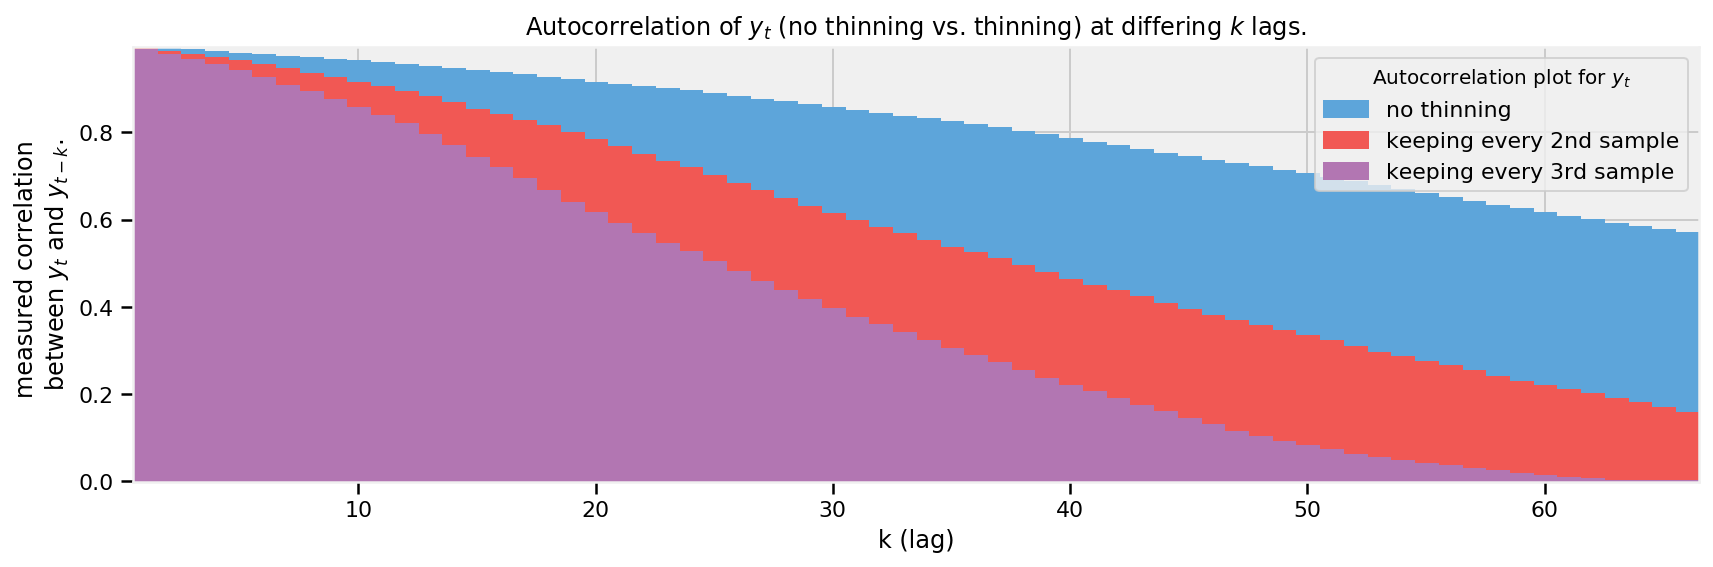

In [75]:
max_x = 200 // 3 + 1
x = np.arange(1, max_x)

plt.bar(x, autocorr(y_t)[1:max_x], edgecolor=colors[0],
        label="no thinning", color=colors[0], width=1)
plt.bar(x, autocorr(y_t[::2])[1:max_x], edgecolor=colors[1],
        label="keeping every 2nd sample", color=colors[1], width=1)
plt.bar(x, autocorr(y_t[::3])[1:max_x], width=1, edgecolor=colors[2],
        label="keeping every 3rd sample", color=colors[2])

plt.autoscale(tight=True)
plt.legend(title="Autocorrelation plot for $y_t$", loc="upper right")
plt.ylabel("measured correlation \nbetween $y_t$ and $y_{t-k}$.")
plt.xlabel("k (lag)")
plt.title("Autocorrelation of $y_t$ (no thinning vs. thinning) \
at differing $k$ lags.");

## Useful tips for MCMC
Bayesian inference would be the de facto method if it weren't for MCMC's computational difficulties. In fact, MCMC is what turns most users off practical Bayesian inference. Below I present some good heuristics to help convergence and speed up the MCMC engine:

### Intelligent starting values
It would be great to start the MCMC algorithm off near the posterior distribution, so that it will take little time to start sampling correctly. We can aid the algorithm by telling where we think the posterior distribution will be by specifying the testval parameter in the Stochastic variable creation. In many cases we can produce a reasonable guess for the parameter. For example, if we have data from a Normal distribution, and we wish to estimate the $\mu$ parameter, then a good starting value would be the mean of the data.
```
mu = tfd.Uniform(name="mu", low=0., high=100.).sample(seed=data.mean())
```
For most parameters in models, there is a frequentist estimate of it. These estimates are a good starting value for our MCMC algorithms. Of course, this is not always possible for some variables, but including as many appropriate initial values is always a good idea. Even if your guesses are wrong, the MCMC will still converge to the proper distribution, so there is little to lose.

#### Priors
If the priors are poorly chosen, the MCMC algorithm may not converge, or at least have difficulty converging. Consider what may happen if the prior chosen does not even contain the true parameter: the prior assigns 0 probability to the unknown, hence the posterior will assign 0 probability as well. This can cause pathological results.

For this reason, it is best to carefully choose the priors. Often, lack of covergence or evidence of samples crowding to boundaries implies something is wrong with the chosen priors (see Folk Theorem of Statistical Computing below).

#### The Folk Theorem of Statistical Computing
> If you are having computational problems, probably your model is wrong.

### Conclusion
TFP provides a very strong backend to performing Bayesian inference, mostly because it allows the user to fine-tune the inner workings of MCMC.